# Environment & Imports

In [ ]:
#Imports & basic setup
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# ML / NLP / DL imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported.")


Libraries imported.


## Load dataset

In [ ]:
#Load dataset (use provided local path)
DATA_PATH = "/content/train (1).csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (404351, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# (Step 1:)EDA — Basic info, missing values, target distribution

In [ ]:
#EDA - basic info and missing values
print("Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# If dataset uses 'is_duplicate' as target, ensure name
if 'is_duplicate' in df.columns:
    print("\nTarget distribution (is_duplicate):")
    display(df['is_duplicate'].value_counts())
    display(df['is_duplicate'].value_counts(normalize=True))
else:
    print("\nNo 'is_duplicate' column found. Columns:", df.columns)


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None

Missing values per column:
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Target distribution (is_duplicate):


,count
is_duplicate,
0,255045
1,149306


,proportion
is_duplicate,
0,0.630752
1,0.369248


# EDA — Text length features, basic visuals

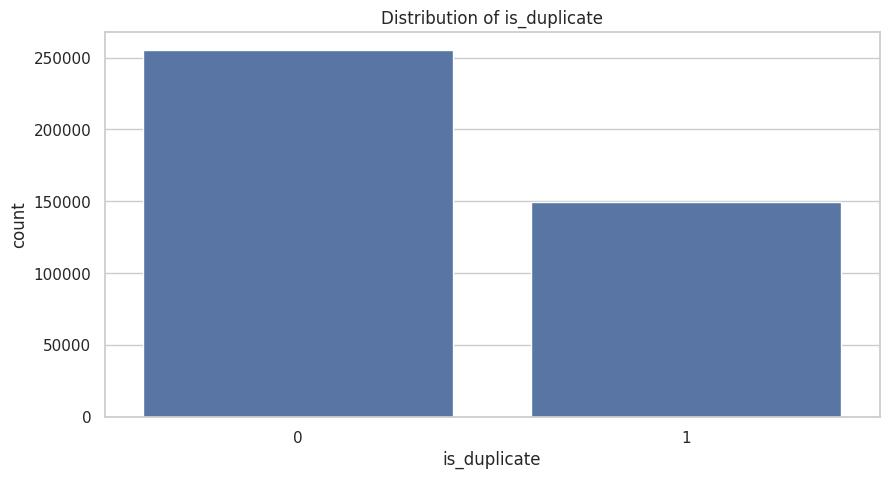

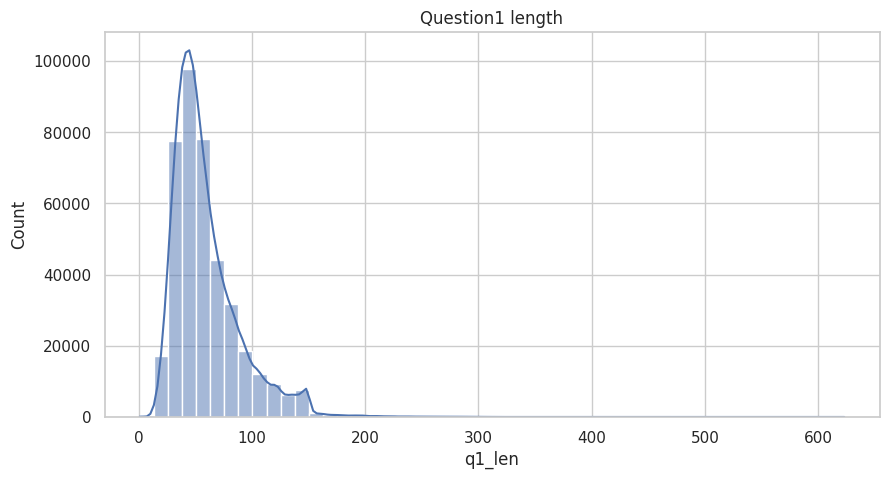

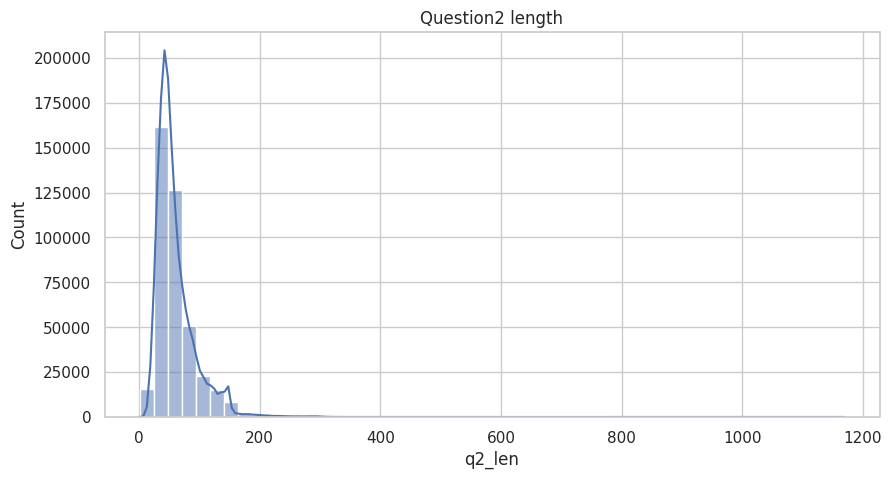

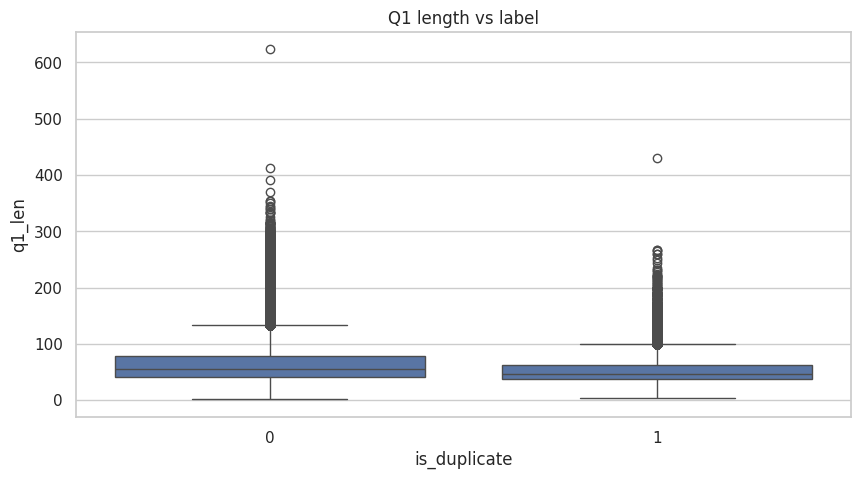

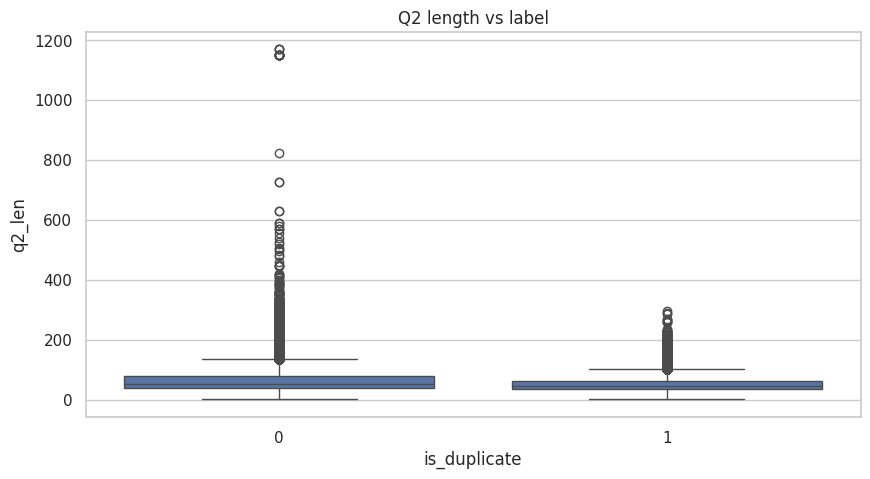

In [ ]:
#Create basic text length / word count features
df['question1'] = df['question1'].astype(str)
df['question2'] = df['question2'].astype(str)

df['q1_len'] = df['question1'].apply(len)
df['q2_len'] = df['question2'].apply(len)
df['q1_words'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_words'] = df['question2'].apply(lambda x: len(x.split()))
df['len_diff'] = abs(df['q1_len'] - df['q2_len'])
df['word_diff'] = abs(df['q1_words'] - df['q2_words'])

# Plot target distribution if available
if 'is_duplicate' in df.columns:
    sns.countplot(x='is_duplicate', data=df)
    plt.title("Distribution of is_duplicate")
    plt.show()

# Plot length distributions
sns.histplot(df['q1_len'], bins=50, kde=True).set_title("Question1 length")
plt.show()
sns.histplot(df['q2_len'], bins=50, kde=True).set_title("Question2 length")
plt.show()

# Boxplots vs label
if 'is_duplicate' in df.columns:
    sns.boxplot(x='is_duplicate', y='q1_len', data=df).set_title("Q1 length vs label")
    plt.show()
    sns.boxplot(x='is_duplicate', y='q2_len', data=df).set_title("Q2 length vs label")
    plt.show()


# EDA — Common words & wordcloud

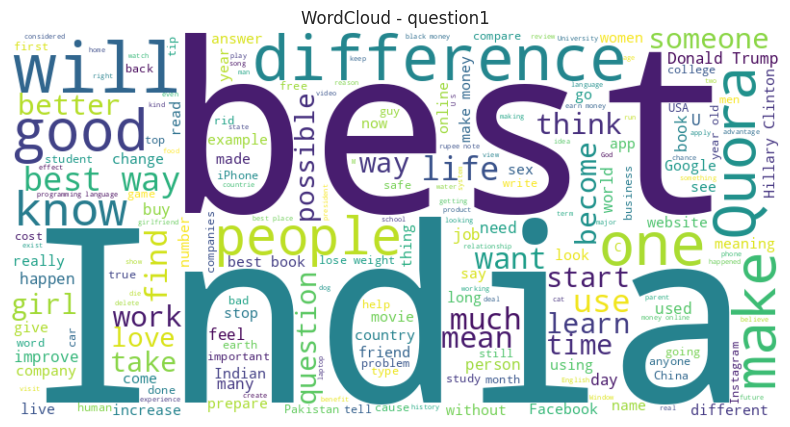

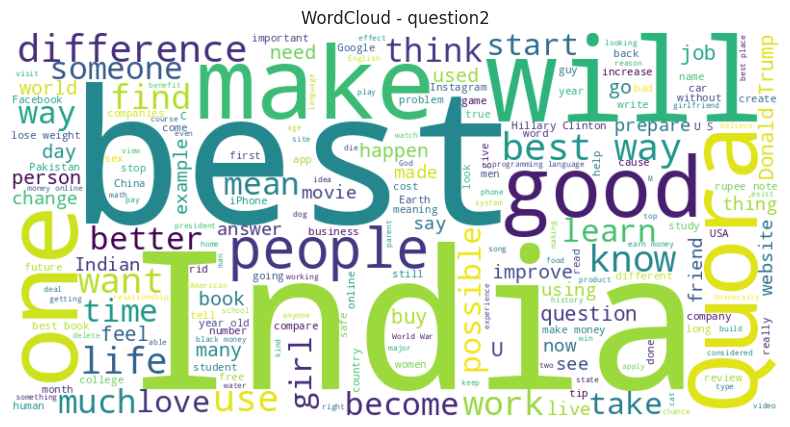

In [ ]:
# WordCloud for quick idea (optional)
!pip install wordcloud --quiet
from wordcloud import WordCloud

text1 = " ".join(df['question1'].values)
text2 = " ".join(df['question2'].values)

wc1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
plt.imshow(wc1, interpolation='bilinear'); plt.axis('off'); plt.title("WordCloud - question1"); plt.show()

wc2 = WordCloud(width=800, height=400, background_color='white').generate(text2)
plt.imshow(wc2, interpolation='bilinear'); plt.axis('off'); plt.title("WordCloud - question2"); plt.show()


# Quick summary print

In [ ]:
#Print a short EDA summary
print("EDA Summary:")
print("Total rows:", df.shape[0])
if 'is_duplicate' in df.columns:
    print("Duplicate ratio:", df['is_duplicate'].mean())
print("Average Q1 words:", df['q1_words'].mean())
print("Average Q2 words:", df['q2_words'].mean())


EDA Summary:
Total rows: 404351
Duplicate ratio: 0.3692484994472624
Average Q1 words: 10.941773360273624
Average Q2 words: 11.181129761024456


# STEP 2: Text Preprocessing prepare tools

In [ ]:
# NLP setup (nltk downloads)
!pip install nltk --quiet
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Cleaning function (lowercase, remove punct, stopwords, lemmatize)

In [ ]:
# Clean function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning
print("Cleaning text columns (this may take a while)...")
df['clean_q1'] = df['question1'].apply(clean_text)
df['clean_q2'] = df['question2'].apply(clean_text)
print("Done cleaning.")


Cleaning text columns (this may take a while)...
Done cleaning.


# Tokenization & cleaned lengths

In [ ]:
# Tokenization and lengths cleaning
df['clean_q1_words'] = df['clean_q1'].apply(lambda x: len(x.split()))
df['clean_q2_words'] = df['clean_q2'].apply(lambda x: len(x.split()))
df[['clean_q1','clean_q2','clean_q1_words','clean_q2_words']].head()


,clean_q1,clean_q2,clean_q1_words,clean_q2_words
0,step step guide invest share market india,step step guide invest share market,7,6
1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,5,10
2,increase speed internet connection using vpn,internet speed increased hacking dns,6,5
3,mentally lonely solve,find remainder math 23 24 math divided 24 23,3,9
4,one dissolve water quikly sugar salt methane c...,fish would survive salt water,10,5


#Feature Extraction - TF-IDF baseline

In [ ]:
#TF-IDF for baseline
tfidf = TfidfVectorizer(max_features=20000)
combined = pd.concat([df['clean_q1'], df['clean_q2']])
tfidf.fit(combined.values)

q1_tfidf = tfidf.transform(df['clean_q1'])
q2_tfidf = tfidf.transform(df['clean_q2'])
print("TF-IDF shapes:", q1_tfidf.shape, q2_tfidf.shape)


TF-IDF shapes: (404351, 20000) (404351, 20000)


# Combine TF-IDF features for baseline model

In [ ]:
#Baseline features concat
from scipy import sparse
X_tfidf = sparse.hstack([q1_tfidf, q2_tfidf])
y = df['is_duplicate'].values if 'is_duplicate' in df.columns else None

print("Combined TF-IDF shape:", X_tfidf.shape)


Combined TF-IDF shape: (404351, 40000)


#Train/Val split for baseline

In [ ]:
# Train/Val split for baseline
if y is not None:
    X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_tfidf, y, test_size=0.15, random_state=42, stratify=y)
    print("Baseline train/val sizes:", X_train_b.shape, X_val_b.shape)
else:
    print("No target 'is_duplicate' found in data.")


Baseline train/val sizes: (343698, 40000) (60653, 40000)


#STEP 3 : Baseline Logistic Regression (quick)

In [ ]:
# Baseline Logistic Regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_b, y_train_b)
pred_b = clf.predict(X_val_b)
print("Baseline Accuracy:", accuracy_score(y_val_b, pred_b))
print("Baseline F1:", f1_score(y_val_b, pred_b))


Baseline Accuracy: 0.751636357641007
Baseline F1: 0.6181689141234918


#Prepare sequences/tokenizer for ANN (LSTM/Siamese)

In [ ]:
# Tokenizer + sequences for Siamese LSTM
MAX_NUM_WORDS = 50000
MAX_SEQ_LEN = 40
EMBEDDING_DIM = 100

texts = pd.concat([df['clean_q1'], df['clean_q2']])
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts.values)

q1_seq = tokenizer.texts_to_sequences(df['clean_q1'])
q2_seq = tokenizer.texts_to_sequences(df['clean_q2'])

q1_pad = pad_sequences(q1_seq, maxlen=MAX_SEQ_LEN, padding='post')
q2_pad = pad_sequences(q2_seq, maxlen=MAX_SEQ_LEN, padding='post')

print("Sequence shapes:", q1_pad.shape, q2_pad.shape)


Sequence shapes: (404351, 40) (404351, 40)


#Train/Val split for ANN

In [ ]:
#Train/Val split for sequence models
if y is not None:
    q1_train, q1_val, q2_train, q2_val, y_train, y_val = train_test_split(
        q1_pad, q2_pad, y, test_size=0.15, random_state=42, stratify=y)
    print("Train size:", q1_train.shape[0], "Val size:", q1_val.shape[0])
else:
    print("No target column; cannot split for supervised training.")


Train size: 343698 Val size: 60653


#Build Siamese LSTM model encoder

In [ ]:
#Siamese LSTM model creation
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
import tensorflow.keras.backend as K
def create_shared_encoder():
    inp = Input(shape=(MAX_SEQ_LEN,))
    x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(inp)
    x = LSTM(128, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    out = Dense(64, activation='relu')(x)
    return Model(inp, out)

shared_encoder = create_shared_encoder()

input_q1 = Input(shape=(MAX_SEQ_LEN,))
input_q2 = Input(shape=(MAX_SEQ_LEN,))

encoded_q1 = shared_encoder(input_q1)
encoded_q2 = shared_encoder(input_q2)

# combine features: abs diff and multiply
abs_diff = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), output_shape=(64,))([encoded_q1, encoded_q2])
mult = Lambda(lambda tensors: tensors[0] * tensors[1], output_shape=(64,))([encoded_q1, encoded_q2])
merged = concatenate([abs_diff, mult])

x = Dense(64, activation='relu')(merged)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_q1, input_q2], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 64)        │  5,125,504 │ input_layer_16[0… │
│ (Functional)        │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 64)        │          0 │ functional_6[0][… │
│                     │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 64)        │          0 │ functional_6[0][… │
│                     │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ lambda_6[0][0],   │
│ (Concatenate)       │                   │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,133,825 (19.58 MB)

 Trainable params: 5,133,825 (19.58 MB)

 Non-trainable params: 0 (0.00 B)

#Train Siamese LSTM with callbacks

In [ ]:
#Train the Siamese LSTM
BATCH_SIZE = 256
EPOCHS = 6

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('siamese_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    [q1_train, q2_train], y_train,
    validation_data=([q1_val, q2_val], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6681 - loss: 0.6131
Epoch 1: val_loss improved from inf to 0.48323, saving model to siamese_best.h5


1343/1343 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.6681 - loss: 0.6131 - val_accuracy: 0.7688 - val_loss: 0.4832
Epoch 2/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7784 - loss: 0.4642
Epoch 2: val_loss improved from 0.48323 to 0.46182, saving model to siamese_best.h5


1343/1343 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.7784 - loss: 0.4642 - val_accuracy: 0.7835 - val_loss: 0.4618
Epoch 3/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8151 - loss: 0.4004
Epoch 3: val_loss did not improve from 0.46182
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.8151 - loss: 0.4004 - val_accuracy: 0.7850 - val_loss: 0.4768
Epoch 4/6
1340/1343 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8403 - loss: 0.3523
Epoch 4: val_loss did not improve from 0.46182
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8403 - loss: 0.3523 - val_accuracy: 0.7814 - val_loss: 0.5066


#STEP 4 START: Evaluation metrics (accuracy, precision, recall, F1)

In [ ]:
#Evaluate model on val set
val_probs = model.predict([q1_val, q2_val], batch_size=1024)
val_pred = (val_probs > 0.5).astype(int).ravel()

print("Accuracy:", accuracy_score(y_val, val_pred))
print("Precision:", precision_score(y_val, val_pred))
print("Recall:", recall_score(y_val, val_pred))
print("F1 score:", f1_score(y_val, val_pred))
print("\nClassification report:\n", classification_report(y_val, val_pred))


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Accuracy: 0.7834896872372348
Precision: 0.7189656802495982
Recall: 0.6790944811573495
F1 score: 0.6984615384615385

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83     38257
           1       0.72      0.68      0.70     22396

    accuracy                           0.78     60653
   macro avg       0.77      0.76      0.76     60653
weighted avg       0.78      0.78      0.78     60653



#Confusion matrix plot

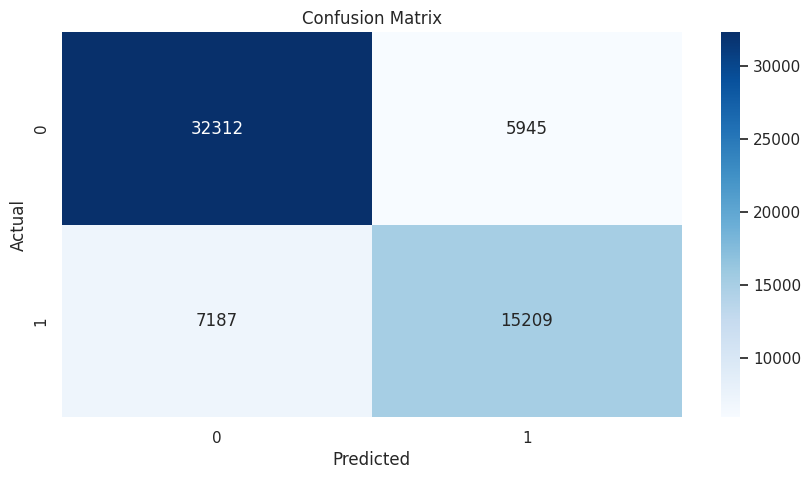

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#ROC-AUC curve

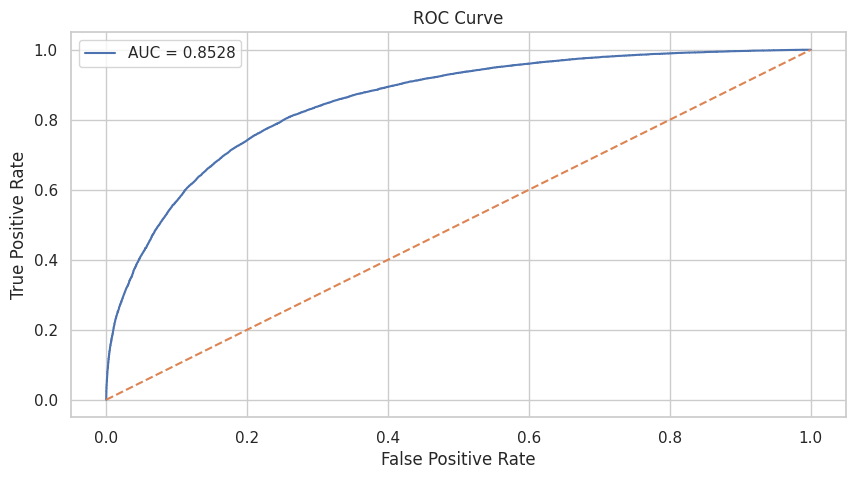

AUC: 0.8528110611539186


In [ ]:
# ROC AUC
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print("AUC:", roc_auc)


#Save evaluation plots

In [ ]:
# Save the model and tokenizer for later use
model.save('siamese_lstm_model.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Saved model and tokenizer.")


Saved model and tokenizer.


#STEP 5: Model Tuning — try activations & optimizers

In [ ]:
# Quick experiments with activation and optimizer
from tensorflow.keras.optimizers import Adam, SGD

def build_simple_siamese(activation='relu', optimizer='adam'):
    # small encoder
    inp = Input(shape=(MAX_SEQ_LEN,))
    x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(inp)
    x = LSTM(64)(x)
    x = Dense(32, activation=activation)(x)
    encoder = Model(inp, x)

    i1 = Input(shape=(MAX_SEQ_LEN,))
    i2 = Input(shape=(MAX_SEQ_LEN,))
    e1 = encoder(i1)
    e2 = encoder(i2)
    diff = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([e1, e2])
    mul = Lambda(lambda tensors: tensors[0] * tensors[1])([e1, e2])
    m = concatenate([diff, mul])
    out = Dense(32, activation=activation)(m)
    out = Dense(1, activation='sigmoid')(out)
    mod = Model([i1,i2], out)
    mod.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return mod

# Try ReLU + Adam and Sigmoid + SGD quickly (train short)
m1 = build_simple_siamese('relu', Adam(0.001))
m2 = build_simple_siamese('sigmoid', SGD(0.001))

m1.fit([q1_train,q2_train], y_train, epochs=3, batch_size=256, validation_data=([q1_val,q2_val], y_val), verbose=1)
m2.fit([q1_train,q2_train], y_train, epochs=3, batch_size=256, validation_data=([q1_val,q2_val], y_val), verbose=1)

print("Evaluate m1:", m1.evaluate([q1_val,q2_val], y_val))
print("Evaluate m2:", m2.evaluate([q1_val,q2_val], y_val))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6990 - loss: 0.5701 - val_accuracy: 0.7629 - val_loss: 0.4881
Epoch 2/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7741 - loss: 0.4687 - val_accuracy: 0.7699 - val_loss: 0.4798
Epoch 3/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8006 - loss: 0.4219 - val_accuracy: 0.7700 - val_loss: 0.4797
Epoch 1/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6304 - loss: 0.6980 - val_accuracy: 0.6308 - val_loss: 0.6589
Epoch 2/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6304 - loss: 0.6589 - val_accuracy: 0.6308 - val_loss: 0.6586
Epoch 3/3
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6304 - loss: 0.6588 - val_accuracy: 0.6308 - val_loss: 0.6586
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7711 - loss: 0.4800
Evaluate m1: [0.47971248626708984, 0.769970178604126]
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6298 - loss: 0.6591
Evalua

#Hyperparameter Random Search example learning rate

In [ ]:
#Random search over learning rates (small experiment)
learning_rates = [1e-2, 1e-3, 1e-4]
results_lr = {}

for lr in learning_rates:
    tmp = build_simple_siamese('relu', Adam(lr))
    tmp.fit([q1_train,q2_train], y_train, epochs=3, batch_size=256, verbose=0)
    score = tmp.evaluate([q1_val,q2_val], y_val, verbose=0)[1]
    results_lr[lr] = score
    print("lr:", lr, "val acc:", score)

print("LR results:", results_lr)


lr: 0.01 val acc: 0.7950472235679626
lr: 0.001 val acc: 0.7807363271713257
lr: 0.0001 val acc: 0.7661451101303101
LR results: {0.01: 0.7950472235679626, 0.001: 0.7807363271713257, 0.0001: 0.7661451101303101}


#Grid search over batch size and epochs

In [ ]:
#Grid search for batch sizes and epochs
batch_sizes = [128, 256]
epoch_list = [3, 5]

grid_results = {}
for b in batch_sizes:
    for e in epoch_list:
        tmp = build_simple_siamese('relu', Adam(0.001))
        tmp.fit([q1_train,q2_train], y_train, epochs=e, batch_size=b, verbose=0)
        acc = tmp.evaluate([q1_val,q2_val], y_val, verbose=0)[1]
        grid_results[(b,e)] = acc
        print("batch",b,"epochs",e,"-> acc",acc)

print("Grid results:", grid_results)


batch 128 epochs 3 -> acc 0.774570107460022
batch 128 epochs 5 -> acc 0.7819234132766724
batch 256 epochs 3 -> acc 0.7798954844474792
batch 256 epochs 5 -> acc 0.7775378227233887
Grid results: {(128, 3): 0.774570107460022, (128, 5): 0.7819234132766724, (256, 3): 0.7798954844474792, (256, 5): 0.7775378227233887}


#Final tuned model training (use best found hyperparams)

In [ ]:
#Final training with chosen hyperparams (example uses defaults)
best_batch = 256
best_epochs = 6
final_model = build_simple_siamese('relu', Adam(0.001))
final_model.fit([q1_train,q2_train], y_train, epochs=best_epochs, batch_size=best_batch, validation_data=([q1_val,q2_val], y_val), callbacks=[EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)])
final_preds = (final_model.predict([q1_val,q2_val])>0.5).astype(int).ravel()
print("Final Accuracy:", accuracy_score(y_val, final_preds))
print("Final F1:", f1_score(y_val, final_preds))


Epoch 1/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6946 - loss: 0.5737 - val_accuracy: 0.7669 - val_loss: 0.4913
Epoch 2/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7817 - loss: 0.4594 - val_accuracy: 0.7854 - val_loss: 0.4585
Epoch 3/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8080 - loss: 0.4079 - val_accuracy: 0.7785 - val_loss: 0.4665
Epoch 4/6
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8306 - loss: 0.3664 - val_accuracy: 0.7779 - val_loss: 0.4725
1896/1896 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Final Accuracy: 0.7854022059914596
Final F1: 0.7075976097407557
